In [12]:
from pyspark.sql import SparkSession
#spark session is the entry point for using pyspark
#its instance is to be created usind builder



In [13]:
spark = SparkSession.builder.appName("customer_seg").getOrCreate()

In [16]:
df = spark.read.csv("Mall_Customers.csv" ,header=True , inferSchema =True)

In [48]:
df.show(2)

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
+----------+------+---+------------------+----------------------+
only showing top 2 rows



In [64]:
df = df.na.drop()

In [65]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


In [66]:
df.columns

['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [114]:
assemble = VectorAssembler(inputCols=[ 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], outputCol='features')
#Vectorassembler to is a transformer that converts a set of features into 
#a single vector column often referred to as features

In [115]:
assembled_data=assemble.transform(df)

In [116]:
assembled_data.show(2)

+----------+------+---+------------------+----------------------+----------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|        features|
+----------+------+---+------------------+----------------------+----------------+
|         1|  Male| 19|                15|                    39|[19.0,15.0,39.0]|
|         2|  Male| 21|                15|                    81|[21.0,15.0,81.0]|
+----------+------+---+------------------+----------------------+----------------+
only showing top 2 rows



In [117]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)
#to standardize the data to bring them to a comparable scale
#Euclidean distance is always impacted more by variables on a higher scale, hence it’s important to scale the variables out.

+----------+------+---+------------------+----------------------+----------------+--------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|        features|        standardized|
+----------+------+---+------------------+----------------------+----------------+--------------------+
|         1|  Male| 19|                15|                    39|[19.0,15.0,39.0]|[1.36015391423519...|
|         2|  Male| 21|                15|                    81|[21.0,15.0,81.0]|[1.50332801047048...|
+----------+------+---+------------------+----------------------+----------------+--------------------+
only showing top 2 rows



In [118]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [119]:

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')


#Silhouette Score using ClusteringEvaluator() measures how close each point in one cluster is
#to points in the neighboring clusters 
#thus helping in figuring out clusters that are compact and well-spaced out.
#

In [120]:
silhouette_score = []
print("""
Silhoutte Scores for K Mean Clustering
======================================
Model\tScore\t
=====\t=====\t
""")
for k in range(2,11):
  kmeans_algo = KMeans(featuresCol='standardized',k=k)
  kmeans_fit = kmeans_algo.fit(data_scale_output)
  output = kmeans_fit.transform(data_scale_output)
  score=evaluator.evaluate(output)
    
  silhouette_score.append(score)
  print(f"K{k}\t{round(score,2)}\t")


Silhoutte Scores for K Mean Clustering
Model	Score	
=====	=====	

K2	0.49	
K3	0.45	
K4	0.51	
K5	0.6	
K6	0.56	
K7	0.58	
K8	0.57	
K9	0.56	
K10	0.59	


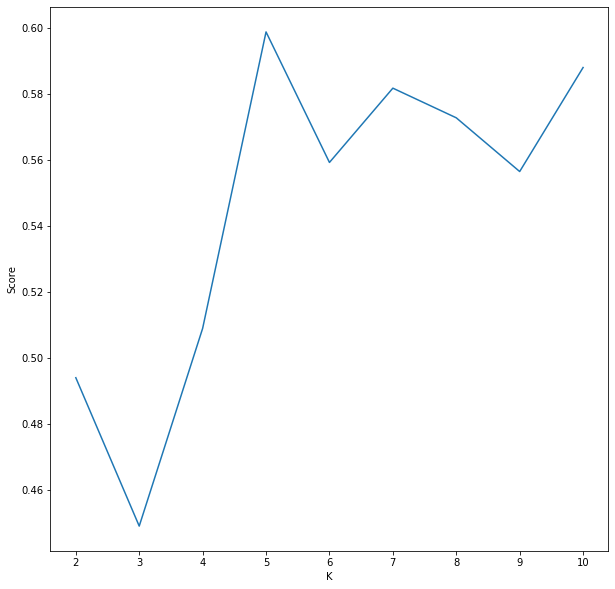

In [113]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(range(2,11), silhouette_score)
ax.set_xlabel("K")
ax.set_ylabel("Score");

In [122]:
assemble = VectorAssembler(inputCols=[  'Annual Income (k$)', 'Spending Score (1-100)'], outputCol='features')

In [123]:
assembled_data=assemble.transform(df)

In [124]:
assembled_data.show(2)

+----------+------+---+------------------+----------------------+-----------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|   features|
+----------+------+---+------------------+----------------------+-----------+
|         1|  Male| 19|                15|                    39|[15.0,39.0]|
|         2|  Male| 21|                15|                    81|[15.0,81.0]|
+----------+------+---+------------------+----------------------+-----------+
only showing top 2 rows



In [125]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+----------+------+---+------------------+----------------------+-----------+--------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|   features|        standardized|
+----------+------+---+------------------+----------------------+-----------+--------------------+
|         1|  Male| 19|                15|                    39|[15.0,39.0]|[0.57110829030364...|
|         2|  Male| 21|                15|                    81|[15.0,81.0]|[0.57110829030364...|
+----------+------+---+------------------+----------------------+-----------+--------------------+
only showing top 2 rows



In [126]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [127]:
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

In [128]:
silhouette_score = []
print("""
Silhoutte Scores for K Mean Clustering
======================================
Model\tScore\t
=====\t=====\t
""")
for k in range(2,11):
  kmeans_algo = KMeans(featuresCol='standardized',k=k)
  kmeans_fit = kmeans_algo.fit(data_scale_output)
  output = kmeans_fit.transform(data_scale_output)
  score=evaluator.evaluate(output)
    
  silhouette_score.append(score)
  print(f"K{k}\t{round(score,2)}\t")


Silhoutte Scores for K Mean Clustering
Model	Score	
=====	=====	

K2	0.45	
K3	0.63	
K4	0.66	
K5	0.62	
K6	0.53	
K7	0.72	
K8	0.7	
K9	0.63	
K10	0.58	


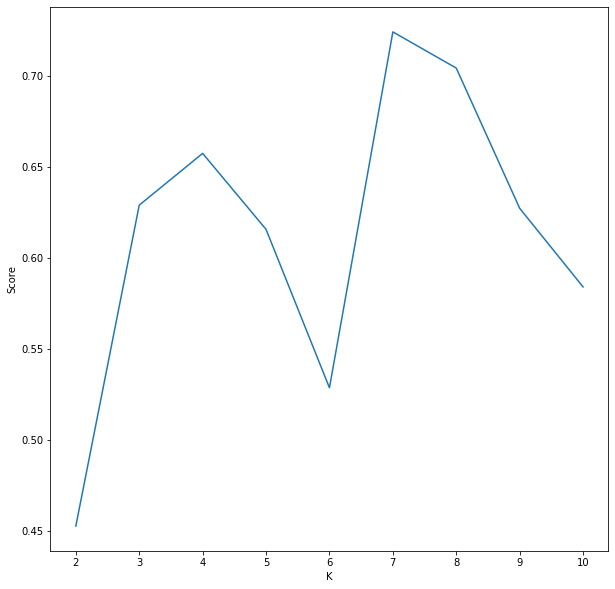

In [129]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(range(2,11), silhouette_score)
ax.set_xlabel("K")
ax.set_ylabel("Score");

In [130]:
assemble = VectorAssembler(inputCols=[ 'Age' ,'Spending Score (1-100)'], outputCol='features')

In [131]:
assembled_data=assemble.transform(df)
assembled_data.show(2)

+----------+------+---+------------------+----------------------+-----------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|   features|
+----------+------+---+------------------+----------------------+-----------+
|         1|  Male| 19|                15|                    39|[19.0,39.0]|
|         2|  Male| 21|                15|                    81|[21.0,81.0]|
+----------+------+---+------------------+----------------------+-----------+
only showing top 2 rows



In [132]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+----------+------+---+------------------+----------------------+-----------+--------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|   features|        standardized|
+----------+------+---+------------------+----------------------+-----------+--------------------+
|         1|  Male| 19|                15|                    39|[19.0,39.0]|[1.36015391423519...|
|         2|  Male| 21|                15|                    81|[21.0,81.0]|[1.50332801047048...|
+----------+------+---+------------------+----------------------+-----------+--------------------+
only showing top 2 rows



In [133]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [135]:
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

In [136]:
silhouette_score = []
print("""
Silhoutte Scores for K Mean Clustering
======================================
Model\tScore\t
=====\t=====\t
""")
for k in range(2,11):
  kmeans_algo = KMeans(featuresCol='standardized',k=k)
  kmeans_fit = kmeans_algo.fit(data_scale_output)
  output = kmeans_fit.transform(data_scale_output)
  score=evaluator.evaluate(output)
    
  silhouette_score.append(score)
  print(f"K{k}\t{round(score,2)}\t")


Silhoutte Scores for K Mean Clustering
Model	Score	
=====	=====	

K2	0.65	
K3	0.62	
K4	0.61	
K5	0.59	
K6	0.64	
K7	0.63	
K8	0.6	
K9	0.57	
K10	0.59	


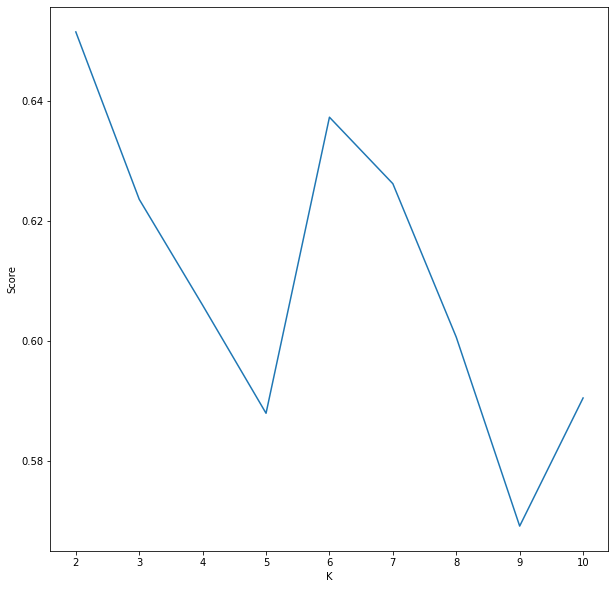

In [137]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(range(2,11), silhouette_score)
ax.set_xlabel("K")
ax.set_ylabel("Score");

In [ ]:
|